# Imbalanced Classification: Phoneme Classification

### Main techniques used:
* Scaling (Numeric Vars)
* Oversampling

### Background:
* The Phoneme dataset is an example of imbalanced classification, on vowel sounds from European languages as either nasal or oral in speech recognition. The majority class is nasal and the minority class are oral vowels.
* We will explore the usage of oversampling techniques to help with the imbalanced ratio.

In [1]:
# import necessary libraries
from collections import Counter

from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

### Simple EDA of the data

In [2]:
filename = 'phoneme.csv'
dataframe = read_csv(filename, header=None)

print(dataframe.shape)

# Summarize the class distributions
target = dataframe.values[:, -1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f"Class = {k}, Count = {v}, Percentage = {per:.3f}%")

(5404, 6)
Class = 0.0, Count = 3818, Percentage = 70.651%
Class = 1.0, Count = 1586, Percentage = 29.349%


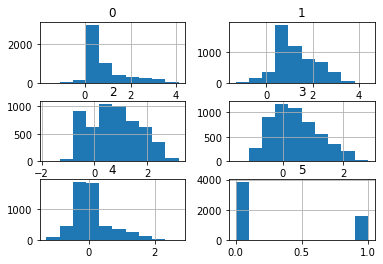

In [3]:
dataframe.hist()
pyplot.show()

**Note:** We can see that there is a modest class imbalance with around 70.7% for the majority class (nasal), and 30% for the minority class (oral).

**Note:** We also see that the numeric variables have differing scales, although they are already somewhat Gaussian in nature. It may be useful to perform some scaling (normalization).

### Evaluate baseline model for reference

In [4]:
# Define custom functions

def load_dataset(full_path):
    data = read_csv(full_path, header=None)
    data = data.values
    X, y = data[:, :-1], data[:, -1]
    return X, y

def evaluate_model(X, y, model):
    # Define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=88)
    # Define model evaluation metric
    metric = make_scorer(geometric_mean_score)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [5]:
full_path = 'phoneme.csv'
X, y = load_dataset(full_path)

# Summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

# Define the baseline reference model
model = DummyClassifier(strategy='uniform')

# Evaluate the baseline model
scores = evaluate_model(X, y, model)

# Summarize performance
print(f"Mean G-Mean: {mean(scores):.3f} ({std(scores):.3f})")

(5404, 5) (5404,) Counter({0.0: 3818, 1.0: 1586})
Mean G-Mean: 0.500 (0.022)


**Note:** We can see that the baseline reference model provides a lower limit on model skill with a G-mean score of about 0.5. From here, we can go on to further evaluate classifier models and oversampling techniques that may boost performance.

### Evaluate classifiers and select best before performing oversampling techniques

In [6]:
# Define classififer models to test
def get_models():
    models, names = list(), list()
    # Logistic Regression
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR')
    # Support Vector Machine Classifier
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    # Bagging
    models.append(BaggingClassifier(n_estimators=1000))
    names.append('BAG')
    # Random Forests
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    # Extra Trees Classifier
    models.append(ExtraTreesClassifier(n_estimators=1000))
    names.append('ET')
    return models, names

In [7]:
full_path = 'phoneme.csv'
X, y = load_dataset(full_path)

# Define classifier models here
models, names = get_models()

In [8]:
results = list()
for i in range(len(models)):
    # Evaluate model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # Sumarize and store scores
    print(f"{names[i]}: {mean(scores):.3f} ({std(scores):.3f})")

LR: 0.636 (0.026)
SVM: 0.802 (0.019)
BAG: 0.885 (0.016)
RF: 0.891 (0.014)
ET: 0.897 (0.014)


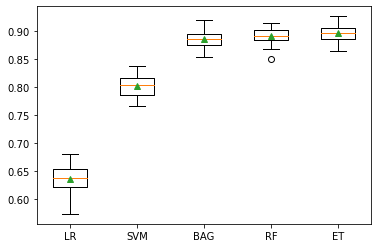

In [9]:
# Visualize above results for classifiers
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Note:** Looking at the above results, it seems that when evaluating a group of classifiers (with default hyperparameters), the ExtraTreesClassifier() has the best potential. We can choose to use this when further evaluating multiple oversampling techniques to improve performance.

### Evaluate oversampling techniques with best potential classifier

**Note:** We will normalize the input variables because most oversampling techniques will make use of a nearest neighbor algorithm internally and it is important that all variables have the same scale when using this technique. We can then go on to perform oversampling and finally train the chosen classifier model.

In [10]:
# Define oversampling techniques to test

def get_models():
    models, names = list(), list()
    # RandomOverSampler
    models.append(RandomOverSampler())
    names.append('ROS')
    # SMOTE
    models.append(SMOTE())
    names.append('SMOTE')
    # BorderlineSMOTE
    models.append(BorderlineSMOTE())
    names.append('BLSMOTE')
    # SVMSMOTE
    models.append(SVMSMOTE())
    names.append('SVMSMOTE')
    # ADASYn
    models.append(ADASYN())
    names.append('ADASYN')
    return models, names

In [11]:
full_path = 'phoneme.csv'
X, y = load_dataset(full_path)

# Define models
models, names = get_models()

In [14]:
results = list()

# Evaluate each model
for i in range(len(models)):
    # Define the classifier model
    model = ExtraTreesClassifier(n_estimators=1000)
    # Define the pipeline steps
    steps = [('s', MinMaxScaler()),('o', models[i]), ('m', model)]
    # Define the pipeline itself
    pipeline = Pipeline(steps=steps)
    # Evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # Summarize and store results
    print(f"{models[i]}: {mean(scores):.4f} ({std(scores):.4f})")

RandomOverSampler(): 0.8946 (0.0144)
SMOTE(): 0.9062 (0.0124)
BorderlineSMOTE(): 0.9067 (0.0126)
SVMSMOTE(): 0.9087 (0.0130)
ADASYN(): 0.9104 (0.0113)


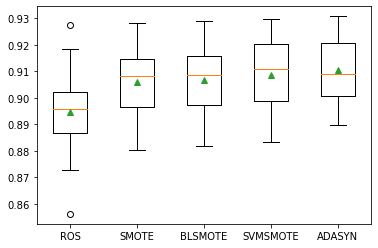

In [15]:
# Visualize the above results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Note:** Looking at the results, we can see that oversampling with the ADASYN technique paired with the ExtraTreesClassifier had the best results on this datset, with a G-mean score of 0.9104.

### Further steps:
* One can further tune the hyperparameters of the best performing model.
* Standard approaches such as GridSearchCV can be applied.